## In this notebook we make basic data processing
### As a result we produce three files: cases.csv, pdelay.csv,onset.csv

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime
from datetime import timedelta

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                     'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                     'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                     'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland',
                    'United_Kingdom', 'Belarus']

In [3]:
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/'
eu_countries = pd.read_csv(url,
                     usecols=['dateRep', 'countriesAndTerritories', 'cases'],
                     parse_dates=['dateRep'],dayfirst=True,
                     index_col=['countriesAndTerritories', 'dateRep']).sort_index()

In [4]:
eu_countries.index.rename(names=['country', 'date'], inplace=True)

In [5]:
# the data coming from ECDC starts at different dates for different countries
# and many countries have leading zeros for Jan and Feb. Let's set a common cutoff
# date for all European countries that simplifies further data processing
dates_considered = pd.date_range('02-01-2020', pd.Timestamp.today())

In [6]:
targets = eu_countries.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
countries = eu_countries[targets]

# Cannot really do it using groupby.transform since this intrinsically increases the length
def prepare_country(country, data):
    dates_old = data.index.get_level_values('date')
    # Adding all the dates and zero entries in between non-zero entries (see Poland 03-05, 03-06)
    dates_new = pd.date_range(start=dates_old[0],end=dates_old[-1])
    newindex = pd.MultiIndex.from_tuples([(country,date) for date in dates_new], names=['country','date'])
    return data.reindex(newindex,fill_value=0.0)

countries = pd.concat([prepare_country(country,data) for country, data in countries.groupby('country')])

In [7]:
eu_countries.loc['Poland'].tail(10)

,cases
date,
2020-06-15,375
2020-06-16,396
2020-06-17,407
2020-06-18,506
2020-06-19,314
2020-06-20,301
2020-06-21,304
2020-06-22,311
2020-06-23,296


# Fix data issues

In [8]:
# find and fix outliers using Hampel filter
# Impl from: https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

def hampel_filter_pandas(input_series, window_size, n_sigmas=3.0):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    # the use of min_periods is to have rolling window extend towards
    # the end of the data series; in effect, we can apply hampel filter
    # to most recent observations
    # taken from: https://stackoverflow.com/questions/48953313/pandas-rolling-window-boundary-on-start-end-of-series/48953314#48953314
    rolling_window_size = 2*window_size+1
    rolling_median = input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).median()
    rolling_mad = k * input_series.rolling(
        window=rolling_window_size,
        min_periods=(rolling_window_size//2),
        center=True).apply(MAD)
    # print(f'rolling_mad = {rolling_mad}, rolling_median = {rolling_median}')
    diff = np.abs(input_series - rolling_median)
    
    where = diff > (n_sigmas * rolling_mad)
    indices = np.argwhere(where.to_numpy()).flatten()
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices

In [9]:
def transform_cases(case_series):
    filtered, _ = hampel_filter_pandas(case_series, 3, 2.0)
    return filtered

transformed_cases = countries.groupby('country').transform(transform_cases)

In [10]:
transformed_cases.to_csv('data/cases.csv')

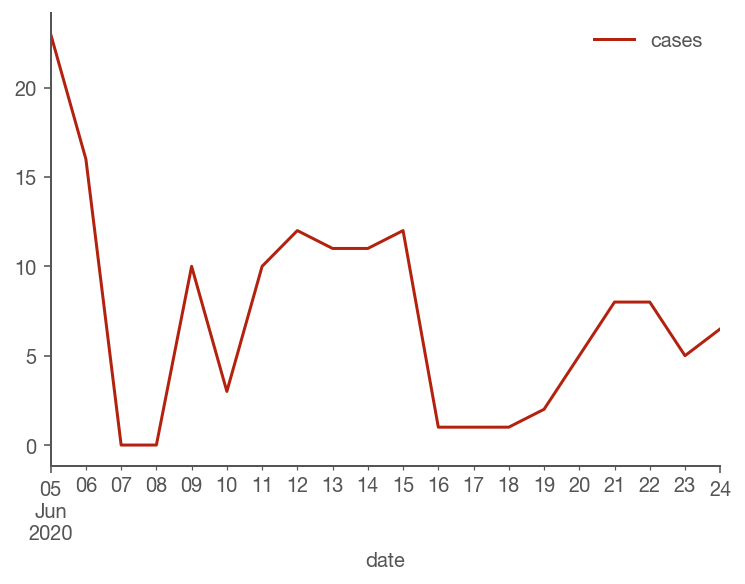

In [11]:
transformed_cases.loc['Hungary'][-20:].plot()

In [12]:
countries = transformed_cases

#### Manual fixes

In [13]:
# hampel filter seems to not be able to deal with this outlier, fixup manually
countries.loc['Spain', '2020-05-25'] = countries.loc['Spain', '2020-05-24']

In [14]:
# again, hampel filter doesn't handle this outlier for some reason
countries.loc['Poland', '2020-06-04'] = countries.loc['Poland', '2020-06-03']

### Integrity check

In [15]:
# Make sure that all the countries have current data
today = datetime.combine(date.today(), datetime.min.time())
yesterday = datetime.combine(date.today() - timedelta(1), datetime.min.time())
last_updated = countries.reset_index('date').groupby('country')['date'].max()
is_not_current = last_updated < today
failed = False

try:
    assert is_not_current.sum() == 0
except AssertionError:
    print("Not all countries have updated")
    if (is_not_current.index[is_not_current].tolist() == ['Spain']):
        print("Only Spain didn't update. Spain is a common reporting laggard. Ignoring this errror.")
    else:
        failed = True
        display(last_updated[is_not_current])

# Ensure all case numbers are greater than zero
for country, grp in countries.groupby('country'):
    new_cases = grp.cases.dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {country} has date with negative case counts")
        failed = True
        display(new_cases[~is_positive])
        
assert not failed, "Interrupting notebook's execution due to broken data"
        
# Let's make sure that countries have added cases
# idx = pd.IndexSlice
# assert not countries.loc[idx[:, '2020-04-22':'2020-04-23'], 'cases'].groupby('country').diff().dropna().eq(0).any()

Not all countries have updated
Only Spain didn't update. Spain is a common reporting laggard. Ignoring this errror.


## Determine end of epidemic

Calculate whether an epidemic has ended in the countries we're looking at.

Our definition of an epidemic end: **7-day rolling average is below 10.**

Save dates when it happened to a csv file for a later use in the frontend.

In [16]:
# Takes Series as an argument
def afterPandemic(data):
    dataMeans = data.rolling(window=7).mean()['cases']
    afterPandemic = dataMeans[-1] < 10.0
    dateAfter = (dataMeans < 10.0)[::-1].idxmin()
    return dateAfter if afterPandemic else np.nan
    
endOfPandemic = pd.DataFrame(transformed_cases.groupby('country').apply(lambda x: afterPandemic(x.droplevel(0))),columns=['endDate'])

In [17]:
endOfPandemic.dropna().to_csv('data/end_pandemic.csv',)

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [19]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/linelist.csv"
LINELIST_PATH = 'data/latestdata.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


In [20]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

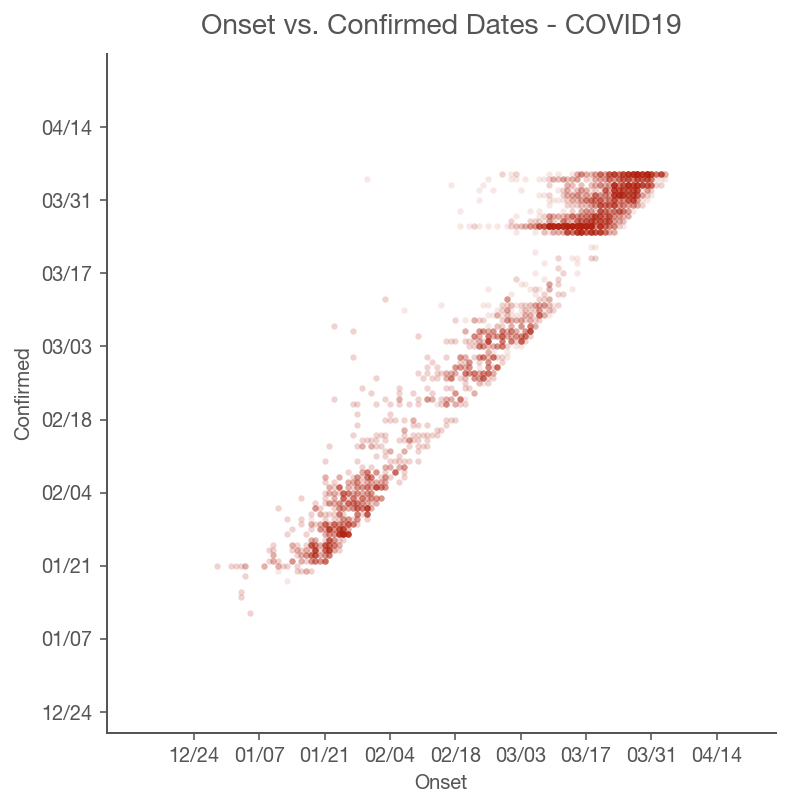

In [21]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

## Construction of the delay distribution

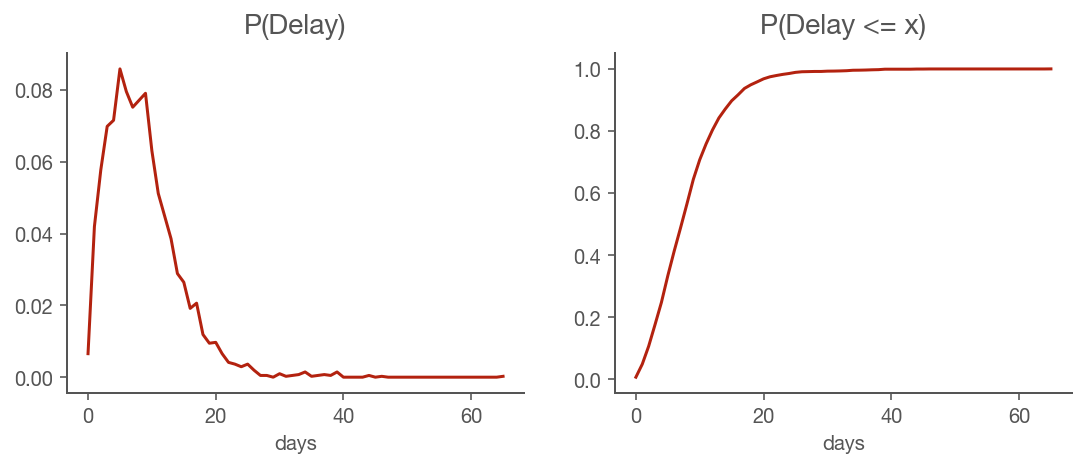

In [22]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
pdelay = delay.value_counts().sort_index()
new_range = np.arange(0, pdelay.index.max()+1)
pdelay = pdelay.reindex(new_range, fill_value=0)
pdelay /= pdelay.sum()

# New version
# K = 21 # BOUND FOR THE pdelay
# pdelay = delay.value_counts().sort_index()
# new_range = np.arange(0, pdelay.index.max()+1)
# pdelay = pdelay.reindex(new_range, fill_value=0)
# pdelay = pdelay[:K]
# pdelay /= pdelay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
pdelay.plot(title='P(Delay)', ax=axes[0])
pdelay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

In [23]:
pdelay_df = pd.DataFrame(pdelay, columns=['pdelay'])
pdelay_df.index.name = 'index'
pdelay_df.to_csv('data/pdelay.csv')

## Onset data

In [24]:
# Maps pd.Series to pd.Series indexed by dates_considered
def confirmed_to_onset(confirmed, pdelay):
    assert not confirmed.isna().any()
    # First, we take a convolution with pdelay to distribute the cases confirmed at a certain time
    # to the appropriate date of onset; Note that we flip it to get inverse chronological
    convolved = np.convolve(confirmed[::-1].values, pdelay)
    # then we flip to in order to get chronological
    data = convolved[::-1]
    first_greater_one = np.flatnonzero(data>=1.0)[0] # First index where the data is >= 1.0
    data = data[first_greater_one:] 
    last_date = confirmed.index[-1]
    index = pd.date_range(end=last_date,periods=len(data))
    # Since covolution increases the size of the array, we clip the data in order to to fit the index
    return pd.Series(data,index=index, name='Onset')

In [25]:
country = "Italy"
data = transformed_cases.loc[country]['cases']
onset = confirmed_to_onset(data, pdelay)

In [26]:
# Adding pd.DataFrame layer to the result of confirmed_to_onset
def process(country, data):
    onset = confirmed_to_onset(data['cases'].droplevel(0), pdelay)
    newindex = pd.MultiIndex.from_tuples([(country,date) for date in onset.index],names=['country','date'])
    return pd.DataFrame(data=onset.values,index=newindex,columns=['Onset'])

countries_onset = pd.concat([process(country,data) for country, data in transformed_cases.groupby('country')])

In [27]:
countries_onset.to_csv('data/onset.csv')

In [28]:
def adjust_onset_for_right_censorship(onset, pdelay):
    cumulative_pdelay = pdelay.cumsum()
    # Calculate the additional ones needed so shapes match
    ones_needed = np.max([len(onset) - len(cumulative_pdelay),0])
    padding_shape = (0, ones_needed)
    # Add ones and flip back
    cumulative_pdelay = np.pad(
        cumulative_pdelay,
        padding_shape,
        constant_values=1)
    cumulative_pdelay = np.flip(cumulative_pdelay[:onset.size])
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_pdelay
    
    return adjusted, cumulative_pdelay

In [29]:
adjusted, cumulative_pdelay = adjust_onset_for_right_censorship(onset, pdelay)

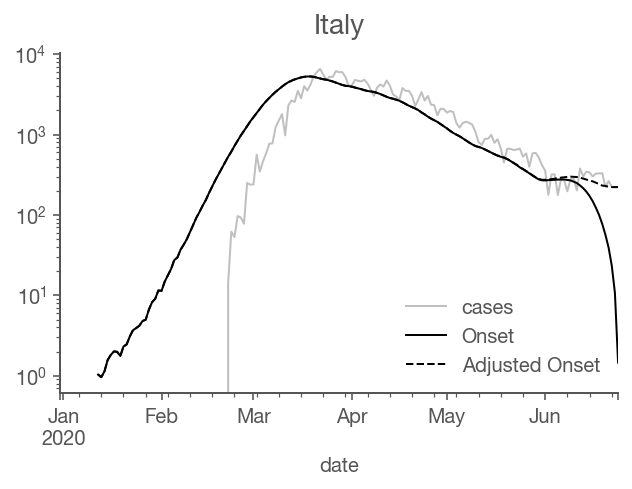

In [30]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed = countries.loc[country]

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=country,
    c='k',
    alpha=.25,
    lw=1,
    logy=True)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1,
    logy=True)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1,
    logy=True)

ax.legend();